In [33]:
from skimage import color, io, draw, img_as_float
from skimage import transform
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import ndimage as ni
import itertools
import pandas as pd
import math
import gc
import os
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split

In [2]:
points_df = pd.DataFrame(pd.read_csv("facial-keypoints-train/gt_train.csv"))

In [3]:
points_df.head()

,filename,x0,y0,x1,y1,x2,y2,x3,y3,x4,...,x9,y9,x10,y10,x11,y11,x12,y12,x13,y13
0,00000.jpg,51,51,127,60,169,65,203,52,68,...,193,84,156,144,92,174,140,180,168,179
1,00001.jpg,21,20,36,18,57,19,80,25,23,...,78,33,43,46,31,61,45,66,60,65
2,00002.jpg,23,116,39,83,47,57,56,19,36,...,62,31,91,86,106,122,115,100,121,81
3,00003.jpg,29,18,63,25,84,32,105,34,38,...,95,45,72,71,46,83,63,87,75,89
4,00004.jpg,31,53,76,44,107,38,136,33,40,...,129,49,111,105,72,137,106,132,126,121


In [4]:
def f(x):
    res = str(x)
    return 'facial-keypoints-train/images/' + '0' * (5 - len(res)) + res + '.jpg'
filenames = [f(x) for x in range(6000)]

init_images = [io.imread(x) for x in filenames]

In [5]:
def draw_points(image, points):
    img = img_as_float(np.copy(image))
    for i in range(14):
        point = draw.circle_perimeter(int(points[i * 2 + 1]), int(points[i * 2]), radius=image.shape[0] // 50)
        img[point] = [1., 0, 0]
    io.imshow(img)

In [31]:
IMG_SIZE = 96
def resize_img(img, points=None):
    if len(img.shape) != 3:
        img = color.gray2rgb(np.copy(img))
    
    tform = transform.SimilarityTransform(scale=(IMG_SIZE * 1. / img.shape[0]))
    img = transform.warp(img, inverse_map=tform.inverse, output_shape=(IMG_SIZE, IMG_SIZE))
    if points is not None:
        ps = np.copy(points)
        for i in range(14):
            ps[2 * i + 1], ps[2 * i] = tform([ps[2 * i + 1], ps[2 * i]])[0]
        return tform, np.array(img), np.array(ps)
    else:
        return tform, np.array(img)

def rotate_img(img, points=None, angle=10):
    tform = tf.SimilarityTransform(scale=1, rotation=np.pi * angle / 180, translation=(0, 1))
    img = tf.warp(img, inverse_map=tform.inverse, output_shape=img.shape)
    if points is not None:
        ps = np.copy(points)
        for i in range(14):
            old_x, old_y = ps[2 * i + 1], ps[2 * i]
            new_x, new_y = tform.inverse([old_x, old_y])[0]
            if abs(old_x - new_x) > 96/2 or abs(old_y - new_y) > 96/2:
#                 return None, None
                pass
#             print(old_x - new_x, old_y-new_y)
            ps[2 * i + 1], ps[2 * i] = new_x, new_y
    return np.array(img), np.array(ps)

In [7]:
del points_df["filename"]

In [8]:
resized_data = np.array(list(map(resize_img, init_images, points_df.values)))
resized_images, resized_points = np.array(resized_data[:, 1]), np.array(resized_data[:, 2])

In [9]:
angles = [5, -5, 10, -10, 15, -15]
images = []
points = []
for a in angles:
#     tmp = map(rotate_img, , resized_images, resized_points)
    rotate_foo = np.vectorize(rotate_img, otypes=[np.ndarray], excluded=['angle'])
    tmp = np.vstack(rotate_foo(resized_images, resized_points, angle=a))
    images.append(tmp[:, 0])
    points.append(tmp[:, 1])
images.append(resized_images)
points.append(resized_points)
images = np.stack(np.concatenate(np.array(images)))
points = np.stack(np.concatenate(np.array(points)))

In [12]:
gc.collect()

0

In [10]:
from lasagne import layers, objectives, regularization, updates
from lasagne.updates import adam
import theano.tensor as T
import theano
import time
import lasagne
import lasagne.layers

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5105)


In [11]:
import lasagne.layers.dnn

In [12]:
X_train, X_val, y_train, y_val = train_test_split(images.astype(np.float32), points.astype(np.float32), test_size=0.15)

In [13]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
    yield inputs[excerpt], targets[excerpt]

In [14]:
input_X, target_y = T.tensor4("X"), T.matrix("y")

nn = lasagne.layers.InputLayer(shape=(None,) + (96, 96) + (3,), input_var=input_X)
nn = lasagne.layers.DimshuffleLayer(nn, (0, 3, 1, 2))

nn = lasagne.layers.dnn.Conv2DDNNLayer(nn, num_filters=32, filter_size=(7, 7))
nn = lasagne.layers.MaxPool2DLayer(nn, pool_size=(2, 2))
nn = lasagne.layers.dropout(nn, p=0.1)

nn = lasagne.layers.dnn.Conv2DDNNLayer(nn, num_filters=64, filter_size=(5, 5))
nn = lasagne.layers.MaxPool2DLayer(nn, pool_size=(2, 2))
nn = lasagne.layers.dropout(nn, p=0.2)

nn = lasagne.layers.dnn.Conv2DDNNLayer(nn, num_filters=128, filter_size=(3, 3))
nn = lasagne.layers.MaxPool2DLayer(nn, pool_size=(2, 2))
nn = lasagne.layers.dropout(nn, p=0.3)

nn = lasagne.layers.dnn.Conv2DDNNLayer(nn, num_filters=128, filter_size=(2, 2))
nn = lasagne.layers.MaxPool2DLayer(nn, pool_size=(2, 2))
nn = lasagne.layers.dropout(nn, p=0.4)

nn = lasagne.layers.DenseLayer(nn, num_units=1000)
nn = lasagne.layers.dropout(nn, p=0.5)
nn = lasagne.layers.DenseLayer(nn, num_units=1000)

nn = lasagne.layers.DenseLayer(nn, 28, nonlinearity=None)

In [15]:
predicted = lasagne.layers.get_output(nn)
final_predicted = lasagne.layers.get_output(nn, deterministic=True)

all_weights = lasagne.layers.get_all_params(nn, trainable=True)

/home/ubuntu/env/src/lasagne/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode=self.mode,
/home/ubuntu/env/src/lasagne/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode=self.mode,
/home/ubuntu/env/src/lasagne/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode=self.mode,
/home/ubuntu/env/src/lasagne/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode=self.mode,
/home/ubuntu/env/src/lasagne/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter

In [16]:
loss = lasagne.objectives.squared_error(final_predicted, target_y).mean()
loss += lasagne.regularization.regularize_network_params(nn, lasagne.regularization.l2) * 2e-3
final_loss = lasagne.objectives.squared_error(final_predicted, target_y).mean()
updates = lasagne.updates.adam(loss, all_weights)

In [17]:
train_fun = theano.function([input_X, target_y], loss, updates=updates, allow_input_downcast=True)
pred_fun = theano.function([input_X], final_predicted, allow_input_downcast=True)
validate_fun = theano.function([input_X, target_y], final_loss, allow_input_downcast=True)

In [18]:
batchsize = 200
val_errs = []
train_errs = []

for epoch in range(2000):
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batchsize, shuffle=True):
        inputs, targets = batch
        train_err += train_fun(inputs, targets)
        train_batches += 1

    val_err = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batchsize, shuffle=False):
        inputs, targets = batch
        err = validate_fun(inputs, targets)
        val_err += err
        val_batches += 1

    if epoch % 50 == 0 and epoch > 0:
        print("epoch: ", epoch, "training loss: ", train_err / train_batches, "  validation loss: ", val_err / val_batches)
    val_errs.append(val_err)
    train_errs.append(train_err)

epoch:  50 training loss:  164.898330688   validation loss:  153.603637695
epoch:  100 training loss:  121.292854309   validation loss:  120.983222961
epoch:  150 training loss:  115.303749084   validation loss:  108.839096069
epoch:  200 training loss:  116.337944031   validation loss:  99.1640396118
epoch:  250 training loss:  93.3070602417   validation loss:  92.2999954224
epoch:  300 training loss:  83.5439147949   validation loss:  88.2797698975
epoch:  350 training loss:  81.3066253662   validation loss:  93.5584106445
epoch:  400 training loss:  90.4236984253   validation loss:  86.2649078369
epoch:  450 training loss:  85.1796798706   validation loss:  86.6595077515
epoch:  500 training loss:  110.23690033   validation loss:  86.2892608643
epoch:  550 training loss:  87.5244903564   validation loss:  87.2199249268
epoch:  600 training loss:  88.737487793   validation loss:  86.1870193481
epoch:  650 training loss:  79.9439239502   validation loss:  85.8116073608
epoch:  700 tra

In [65]:
path_test = os.path.join('facial-keypoints-test', 'images')
X_test = np.zeros((1763, IMG_SIZE, IMG_SIZE, 3))
test_tforms = []
for i in range(1763):
    image = io.imread(os.path.join(path_test, '0{}.jpg'.format(6000 + i)))
    tform, img = resize_img(image)
    test_tforms.append(tf)
    X_test[i] = img    

In [86]:
y_pred = pred_fun(X_test)

In [81]:
for i in range(1763):
    ps = np.copy(y_pred[i])
    tform = test_tforms[i]
    for j in range(14):
        ps[2 * j + 1], ps[2 * j] = tform.inverse([ps[2 * j + 1], ps[2 * j]])[0]
    y_pred[i] = ps

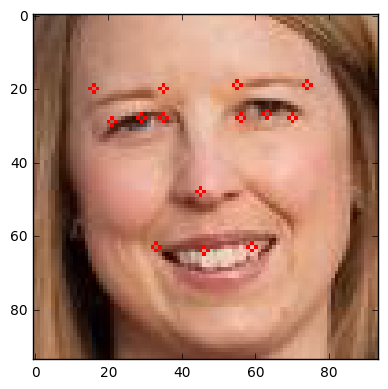

In [92]:
draw_points(io.imread(os.path.join(path_test, '0{}.jpg'.format(6000 + 3))), y_pred[3])

In [93]:
filenames = np.vectorize(lambda i: '0{}.jpg'.format(i))(np.arange(6000, 7763))

In [94]:
df = pd.DataFrame(data=np.concatenate([filenames[:, np.newaxis], y_pred], axis=1))
df.to_csv('first.csv', index=False,
          header=['filename','x0','y0','x1','y1','x2','y2','x3','y3','x4','y4','x5','y5','x6','y6',
                  'x7','y7','x8','y8','x9','y9','x10','y10','x11','y11','x12','y12','x13','y13'])